# Libraries

In [1]:
from pandarallel import pandarallel
import numpy as np

pandarallel.initialize(progress_bar=True, nb_workers=10)
import pandas as pd
import json
import re
from dataclasses import dataclass
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm
import demoji
import emoji
from glob import glob
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import pandas as pd
from nltk.corpus import stopwords
import pandas as pd
import random
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import sys
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import sentence_transformers
from sklearn.cluster import AgglomerativeClustering
from keybert.backend import SentenceTransformerBackend
import seaborn as sns
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import numpy as np
import math
from keybert import KeyBERT
from tqdm.autonotebook import tqdm, trange
import time
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import StratifiedKFold

sys.path.append("..")

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Prepare vectors

### Load data

In [2]:
DATA_PATH = "../data/final_train_data.csv"
train_data = pd.read_csv(DATA_PATH, index_col=0)

## TfIDFVectors

We will use the TFIDF vectorizer as a simple encoder (note: it's not a real transformer) to feed arrays into the model that will be trained as the predictor. For supervised learning, we will use Logistic Regression, and for unsupervised learning, we will use NMF.

The Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer is a statistical tool utilized in natural language processing and information retrieval to assess the significance of a word within a document relative to a larger set of documents, known as a corpus. It is often used to convert text data into numerical vectors that can serve as input for machine learning models.

How does it work? We need to understand two terms:

Term Frequency (TF): How frequently a term appears in a document.
Inverse Document Frequency (IDF): Reduces the significance of words that are common across all documents.
The process is as follows:

The text is broken down into words (tokens), typically converted to lowercase, and common stop words may be removed.
For each term in each document, compute the term frequency.
Compute the IDF value for each term across the entire corpus.
Multiply the TF value by the IDF value for each term, forming a vector for each document.

NOTE: this part of description was used by me also for BBC - week 4 assignment.

In [3]:
nltk.download("stopwords")
word_list = list(stopwords.words("english"))

stop_words = [
    word
    for word in word_list
    if word not in ["not", "no", "i", "my", "but", "my", "myself"]
]
stop_words += [punct for punct in string.punctuation]
vectorizer = CountVectorizer(stop_words=stop_words)
cv_fit = vectorizer.fit_transform(train_data.text_lematized)

words = np.asarray(cv_fit.sum(axis=0))

id2word = {id: word for word, id in vectorizer.vocabulary_.items()}

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [4]:
condition_range = np.logical_and(1000 > words[0], words[0] > 1)

new_stop_words = []
for i in np.argwhere(~condition_range):
    new_stop_words.append(id2word[i[0]])

keep_words = []
for i in np.argwhere(condition_range):
    keep_words.append(id2word[i[0]])

digit_pattern = re.compile("\d+")

keep_words = set([word for word in keep_words if not digit_pattern.search(word)])

len(new_stop_words), len(keep_words)
text_lemmatized = [
    " ".join([word.lower() for word in text.split() if word.lower() in keep_words])
    for text in train_data.text_lematized
]

train_data["text_lematized"] = text_lemmatized

In [5]:
train_data.to_csv("../data/lemmatized_data_final.csv")

# Prepare sampled data

In [6]:
train_data

,asin,title,price,userId,profileName,reviewHelpfulness,overall,reviewTime,reviewSummary,reviewText,...,text_lematized,length,sentiment,total_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,mapped_sentiment,lengths
0,0829814000,Wonderful Worship in Smaller Churches,19.40,AZ0IOBU20TBOP,Rev. Pamela Tinnin,8/10,5.0,991440000,Outstanding Resource for Small Church Pastors,"i just finished the book, "" wonderful Worship ...",...,worship smaller churches ray pastor reread reg...,788,positive,788,0,0,16,0,2,143
1,0829814000,Wonderful Worship in Smaller Churches,19.40,A373VVEU6Z9M0N,Dr. Terry W. Dorsett,1/1,5.0,1291766400,Small Churches CAN Have Wonderful Worship,Many small churches feel like they can not hav...,...,worship ray thou shalt humorous encouragement,349,positive,349,0,0,5,0,2,61
2,0829814000,Wonderful Worship in Smaller Churches,19.40,AGKGOH65VTRR4,"Cynthia L. Lajoy ""Cindy La Joy""",1/1,5.0,1248307200,Not Just for Pastors!,i just finished reading this amazing book and ...,...,entirely congregation ministry depressed accom...,1273,positive,1273,2,0,15,0,2,225
3,0829814000,Wonderful Worship in Smaller Churches,19.40,A3OQWLU31BU1Y,Maxwell Grant,1/1,5.0,1222560000,Small church pastor? This is the book on worship,i had not been a small church pastor very long...,...,pastor ray handful anthony pa pp carl dudley r...,1022,positive,1022,1,0,20,0,2,192
4,0595344550,Whispers of the Wicked Saints,10.95,A3Q12RK71N74LB,Book Reader,7/11,1.0,1117065600,not good,i bought this book because i read some glowing...,...,glow praise criticise urgent editing possibly ...,1023,negative,1023,0,2,21,0,0,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128556,061813512X,The Complete Meat Cookbook,23.10,ASMJXT3DO4D02,"Degalisto ""DCL""",0/0,5.0,1265932800,good book,i am 58 and am a very good cook and i cook a l...,...,massive cooking meat stove oven cooking complaint,514,positive,514,0,0,11,0,2,105
128557,061813512X,The Complete Meat Cookbook,23.10,A1GC87J92WHHUJ,Karl E. Buettner,0/0,5.0,1264032000,Meat Bible,a must! Not only a great cookbook - the writte...,...,meat,102,positive,102,1,0,1,0,2,21
128558,061813512X,The Complete Meat Cookbook,23.10,AXQL0REDIA9C6,K. Wooley,0/0,5.0,1232150400,Fantastic - the best cookbook I own.,I have had this book for awhile now. You can j...,...,awhile meat meat perfectly,260,positive,260,1,0,4,0,2,48
128559,061813512X,The Complete Meat Cookbook,23.10,A2SUK9OWVNW9KU,Paula Ray,0/0,5.0,1031875200,The only guide you'll ever need.,This not only gives you recipes; it gives you ...,...,select meat ingredient roast steak lazy roast ...,392,positive,392,0,0,9,0,2,75


In [7]:
train_data.groupby(["sentiment"]).count()

,asin,title,price,userId,profileName,reviewHelpfulness,overall,reviewTime,reviewSummary,reviewText,cleaned sentences,text_lematized,length,total_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,mapped_sentiment,lengths
sentiment,,,,,,,,,,,,,,,,,,,,
mixed,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500
negative,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384
positive,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677


### Create input data

We want to identify topics using a clustering algorithm. First, we need to consider that each book is referenced by several reviews. Reviews for Book A will be different from reviews for Book B. Therefore, we should concatenate all reviews for each book into a single `text_lemmatized` column.

In [9]:
def sample_texts(group):
    return " ".join(group)


sampled_texts = (
    train_data.groupby("title")["text_lematized"].apply(sample_texts)
).to_dict()

In [22]:
unique_reviews = train_data[["userId", "asin"]].apply(
    lambda x: f'{x["userId"]}_{x["asin"]}', axis=1
)
train_data["composite_keys"] = train_data[["userId", "asin"]].apply(
    lambda x: f'{x["userId"]}_{x["asin"]}', axis=1
)
train_data = train_data[~train_data["sentiment"].isin(["mixed"])]
sampled_data = train_data[train_data["composite_keys"].isin(unique_reviews.unique())]
sampled_data["text_lematized"] = sampled_data["title"].apply(sampled_texts.get)
sampled_data = sampled_data.drop_duplicates("title")
vectorizer = TfidfVectorizer(stop_words=stop_words + new_stop_words)
vectors = vectorizer.fit_transform(sampled_data["text_lematized"])

We end up with unique rows, where each row represents one book. The column "test_lemmatized" contains all reviews for that book.

In [183]:
vectors

<14692x54000 sparse matrix of type '<class 'numpy.float64'>'
	with 1356542 stored elements in Compressed Sparse Row format>

The number of features is very large, so let's reduce them using TruncatedSVD. Why should we use it? TruncatedSVD enhances computational efficiency by lowering the number of features, which speeds up processing and reduces memory usage. This optimization is crucial for large datasets where machine learning model training can be resource-intensive. It's especially beneficial for sparse matrices, like those in text data represented as TF-IDF matrices, as it can generate dense vectors without losing the data's structural integrity.

In [26]:
svd = TruncatedSVD(n_components=1000, random_state=42)
X_after_svd = svd.fit_transform(vectors)

## KMeans

The primary assumption is that we do not want to have too many topics. We aim to limit them to an absolute maximum of 300. Additionally, it is crucial that we do not end up with too many clusters; ideally, we should have around 100. Having more clusters would make the analysis redundant. Our goal is to facilitate quick business decisions without excessive granularity. Introducing too many clusters would make the entire analysis unreadable (there is no value into bringing 10000 clusters, if there are 14000 titles)

In [103]:
range_n_clusters = range(50, 300, 50)
algorithm = ["lloyd", "elkan"]
init = ["k-means++", "random"]
max_iter = [100, 200, 300]

ssd = []
labels = {}
grid_search_results = []

hyperparameter_combinations = list(
    itertools.product(range_n_clusters, algorithm, init, max_iter)
)

for params in tqdm(hyperparameter_combinations):
    print(params)
    n_clusters, alg, init_method, iterations = params
    start_time = time.time()

    kmeans = KMeans(
        n_clusters=n_clusters,
        algorithm=alg,
        init=init_method,
        max_iter=iterations,
        random_state=0,
    )
    kmeans.fit(X_after_svd)
    ssd_value = kmeans.inertia_
    ssd.append(ssd_value)
    end_time = time.time()

    result = {
        "n_clusters": n_clusters,
        "algorithm": alg,
        "init": init_method,
        "max_iter": iterations,
        "ssd": ssd_value,
        "time": end_time - start_time,
    }
    grid_search_results.append(result)

    labels[params] = kmeans.labels_

best_config = min(grid_search_results, key=lambda x: x["ssd"])
print("Best configuration:")
print(best_config)

  0%|          | 0/60 [00:00<?, ?it/s]

(50, 'lloyd', 'k-means++', 100)
(50, 'lloyd', 'k-means++', 200)
(50, 'lloyd', 'k-means++', 300)
(50, 'lloyd', 'random', 100)
(50, 'lloyd', 'random', 200)
(50, 'lloyd', 'random', 300)
(50, 'elkan', 'k-means++', 100)
(50, 'elkan', 'k-means++', 200)
(50, 'elkan', 'k-means++', 300)
(50, 'elkan', 'random', 100)
(50, 'elkan', 'random', 200)
(50, 'elkan', 'random', 300)
(100, 'lloyd', 'k-means++', 100)
(100, 'lloyd', 'k-means++', 200)
(100, 'lloyd', 'k-means++', 300)
(100, 'lloyd', 'random', 100)
(100, 'lloyd', 'random', 200)
(100, 'lloyd', 'random', 300)
(100, 'elkan', 'k-means++', 100)
(100, 'elkan', 'k-means++', 200)
(100, 'elkan', 'k-means++', 300)
(100, 'elkan', 'random', 100)
(100, 'elkan', 'random', 200)
(100, 'elkan', 'random', 300)
(150, 'lloyd', 'k-means++', 100)
(150, 'lloyd', 'k-means++', 200)
(150, 'lloyd', 'k-means++', 300)
(150, 'lloyd', 'random', 100)
(150, 'lloyd', 'random', 200)
(150, 'lloyd', 'random', 300)
(150, 'elkan', 'k-means++', 100)
(150, 'elkan', 'k-means++', 200)
(

In [136]:
df = pd.DataFrame(grid_search_results)
df.sort_values("ssd", ascending=True)

,n_clusters,algorithm,init,max_iter,ssd,time
50,250,lloyd,k-means++,300,3527.025724,4.111364
56,250,elkan,k-means++,300,3527.025724,8.053745
55,250,elkan,k-means++,200,3527.025724,4.276283
54,250,elkan,k-means++,100,3527.025724,4.741620
48,250,lloyd,k-means++,100,3527.025724,3.657211
49,250,lloyd,k-means++,200,3527.025724,3.882657
58,250,elkan,random,200,3626.353101,23.325441
59,250,elkan,random,300,3626.353101,23.713384
52,250,lloyd,random,200,3626.353101,12.217601
53,250,lloyd,random,300,3626.353101,12.491581


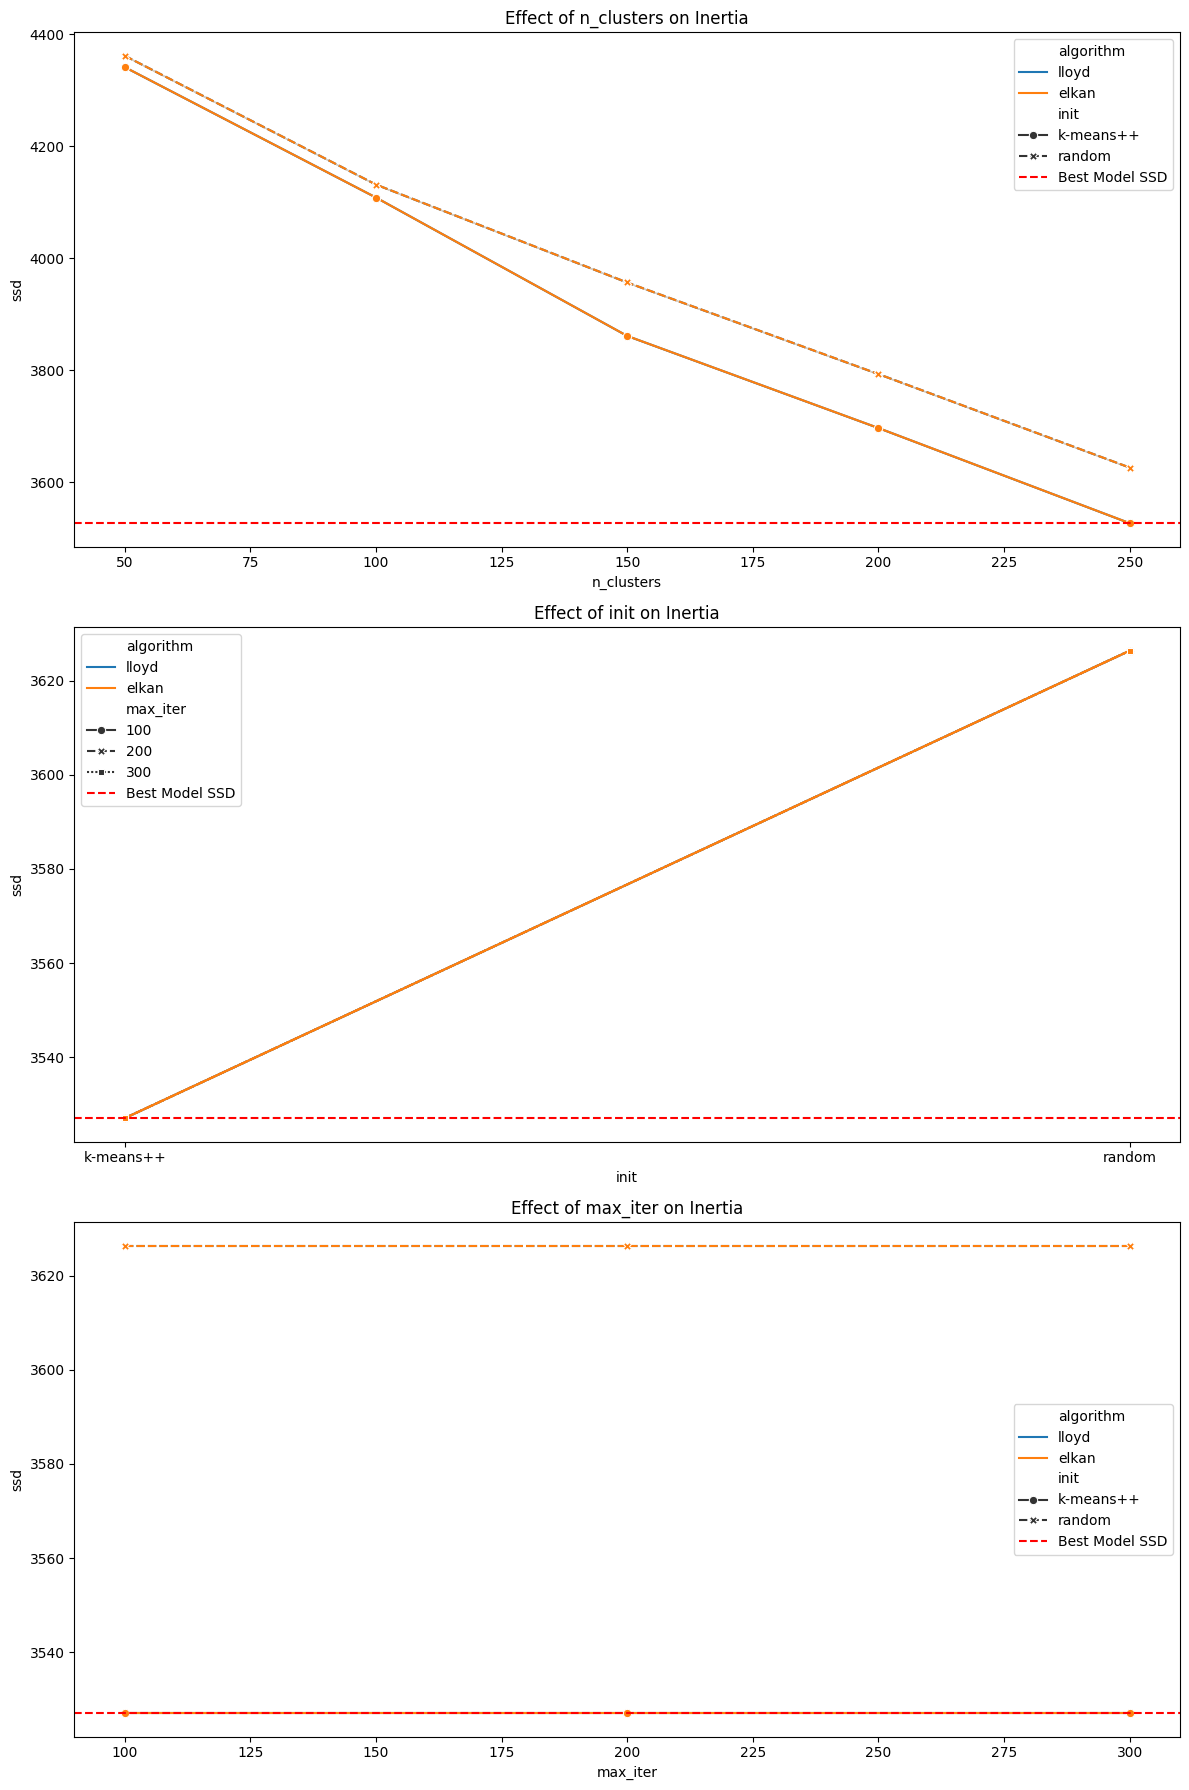

In [133]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
df = pd.DataFrame(grid_search_results)
sns.lineplot(
    data=df,
    x="n_clusters",
    y="ssd",
    hue="algorithm",
    style="init",
    markers=True,
    ax=axes[0],
)
axes[0].axhline(3527.0257237283304, ls="--", color="red", label="Best Model SSD")
axes[0].set_title("Effect of n_clusters on Inertia")
axes[0].legend()

filtered_df = df[df["n_clusters"] == 250]
sns.lineplot(
    data=filtered_df,
    x="init",
    y="ssd",
    hue="algorithm",
    style="max_iter",
    markers=True,
    ax=axes[1],
)
axes[1].axhline(3527.0257237283304, ls="--", color="red", label="Best Model SSD")
axes[1].set_title("Effect of init on Inertia")
axes[1].legend()

sns.lineplot(
    data=filtered_df,
    x="max_iter",
    y="ssd",
    hue="algorithm",
    style="init",
    markers=True,
    ax=axes[2],
)
axes[2].axhline(3527.0257237283304, ls="--", color="red", label="Best Model SSD")
axes[2].set_title("Effect of max_iter on Inertia")
axes[2].legend()

plt.tight_layout()
plt.show()

As observed, changing the `n_clusters` parameter is the only factor that affects the inertia level.

In [184]:
best_config

{'n_clusters': 250,
 'algorithm': 'lloyd',
 'init': 'k-means++',
 'max_iter': 100,
 'ssd': 3527.0257237283304,
 'time': 3.6572108268737793}

In [156]:
kmeans = KMeans(
    **{"n_clusters": 250, "algorithm": "lloyd", "init": "k-means++", "max_iter": 100}
)
kmeans.fit(X_after_svd)

KMeans(max_iter=100, n_clusters=250)

# Naming clusters and creating topics

Let's name the topics using the KeyBert library.

1. Sample examples from the library.
2. Name the topic using the three most common words.
3. Check the distribution of words.
4. Group by negative and positive ratios.

KeyBert utilizes the "paraphrase-MiniLM-L6-v2" model, which is a transformer model optimized for extracting keywords. This transformer will be used to extract labels from the items.

BERT, an abbreviation for Bidirectional Encoder Representations from Transformers, is a transformer-based model designed for natural language processing tasks. Unlike conventional models, BERT processes text bidirectionally, taking into account the context from both the left and right sides of each word in a sentence. This enables BERT to grasp the nuanced meanings of words within various contexts. Its bidirectional nature enhances performance in tasks such as question answering and sentiment analysis. BERT is pre-trained on vast amounts of text and can be fine-tuned for specific applications, making it highly adaptable. Its architecture features multiple layers of encoders that handle text inputs simultaneously, boosting both efficiency and effectiveness in comprehending complex language. 

In [185]:
sampled_data["labels"] = kmeans.labels_

In [186]:
sampled_data["text_lematized"]

0         worship smaller churches ray pastor reread reg...
4         glow praise criticise urgent editing possibly ...
36        interplay diverse caribbean ongoing interactio...
37        everett ferguson ferguson peek christians crit...
40        saint hyacinth meeting rome witness saint domi...
                                ...                        
128460    speaking muslim summarize hadiths prophet muha...
128468     clarity stern berg vocabulary drawing hearing...
128542    castrate expurgate suit anxiety yamato graphic...
128543    december hopelessly killer wave accessible fon...
128544    decent occasionally burn glass sausage frequen...
Name: text_lematized, Length: 14692, dtype: object

In [187]:
def sample_texts(group):
    return " ".join([i[:50] for i in group])[:512]


sampled_texts = sampled_data.groupby("labels")["text_lematized"].apply(sample_texts)

In [188]:
model_name = "paraphrase-MiniLM-L6-v2"

st_model = sentence_transformers.SentenceTransformer(model_name, device="cpu")

kw_model = KeyBERT(model=SentenceTransformerBackend(st_model, batch_size=128))

In [162]:
found_keywords = []
review_texts = sampled_texts.values
batch_size = 128
for start_idx in tqdm(range(0, len(review_texts), batch_size)):
    end_idx = min(start_idx + batch_size, len(review_texts))

    batch_texts = review_texts[start_idx:end_idx]
    batch_keywords = kw_model.extract_keywords(batch_texts)

    found_keywords.extend(batch_keywords)

  0%|          | 0/2 [00:00<?, ?it/s]

In [163]:
def map_words_to_topics(ranked_words_list):
    topics = []
    for ranked_words in ranked_words_list:
        ranked_words.sort(key=lambda x: x[1], reverse=True)
        top_words = [word[0] for word in ranked_words[:3]]
        topic = "-".join(top_words)
        topics.append(topic)
    return topics

In [164]:
def convert_to_dict(data):
    result = {}
    for item in data:
        result[item["title"]] = item["topic"]
    return result

In [165]:
topics = map_words_to_topics(found_keywords)

In [166]:
sampled_data["topic"] = sampled_data["labels"].apply(lambda label: topics[label])

In [167]:
mapping = convert_to_dict(sampled_data[["title", "topic"]].to_dict(orient="records"))

In [168]:
len(set([i for i in mapping.values()]))

250

In [169]:
train_data["topic"] = train_data["title"].apply(mapping.get)

In [170]:
len(train_data["topic"].unique())

250

# Topics

We have unique 250 clusters. We can see from below histogram that number of the clusters vary - and  the largest one have around 140 titles. 

The most of the clusters contains between 1 and 40 positions.

<Axes: >

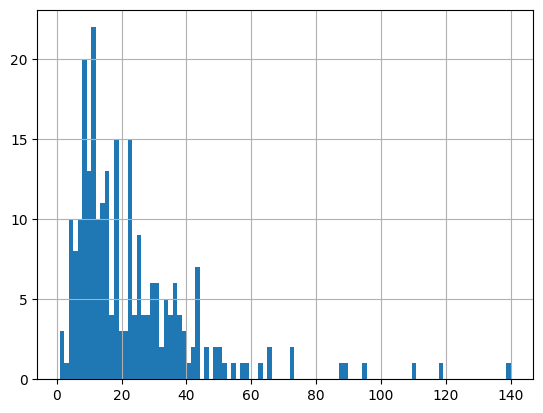

In [171]:
train_data[["topic", "title"]].drop_duplicates("title").groupby(
    ["topic"]
).size().sort_values()[:-1].hist(bins=100)

## How many topics tend to generate the most negative reactions from the audience?

In [172]:
sentiment_counts = (
    train_data.groupby(["topic", "sentiment"]).size().unstack(fill_value=0)
)

In [173]:
sentiment_counts

sentiment,negative,positive
topic,,
abortion-proponent-philoso,2,35
accounting-affair-profit,3,25
adhd-drs-prescr,9,157
adoption-adopt-adoptive,11,125
advertising-ad-marketing,10,40
...,...,...
wireless-wifi-technologist,3,27
wood-woods-burning,9,124
worship-churches-psalms,8,105


In [174]:
topics_with_more_neg = sentiment_counts[
    sentiment_counts["negative"] >= sentiment_counts["positive"]
].index

In [175]:
filtered_df = train_data[train_data["topic"].isin(topics_with_more_neg)]

In [176]:
filtered_df.groupby("topic").size()

Series([], dtype: int64)

**There is no cluster with more negative sentiments overall.** However, we can identify which cluster has the highest proportion of negative sentiments.

In [177]:
sentiment_counts["total_sentiments"] = (
    sentiment_counts["negative"] + sentiment_counts["positive"]
)
sentiment_counts["proportion_negative"] = (
    sentiment_counts["negative"] / sentiment_counts["total_sentiments"]
)

In [181]:
sentiment_counts.sort_values("proportion_negative", ascending=False)

sentiment,negative,positive,total_sentiments,proportion_negative
topic,,,,
clep-exam-civ,28,34,62,0.451613
insurance-insuranc-insura,6,11,17,0.352941
visual-misguide-vb,97,178,275,0.352727
trading-trader-profit,50,105,155,0.322581
circuit-electronics-electronic,24,56,80,0.300000
...,...,...,...,...
press-combat-breaker,0,2,2,0.000000
forgiveness-forgiver-forgive,0,32,32,0.000000
boat-tug-selflessne,0,2,2,0.000000


It appears that the exams (specifically labeled 'clap-exam-civ') and insurance topics are eliciting the most emotional responses.

# Conclusion

# Sources

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

https://www.analyticsvidhya.com/blog/2023/02/topic-modeling-using-latent-dirichlet-allocation-lda/#:~:text=Topic%20modeling%20is%20a%20versatile,within%20a%20corpus%20of%20documents.

https://towardsdatascience.com/elbow-clustering-for-artificial-intelligence-be9c641d9cf8 

https://jalammar.github.io/illustrated-transformer/
